In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [169]:
dataset = pd.read_csv("twitter_data.csv")

In [170]:
dataset.head()

,message,label,followers_count
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",1,208.0
1,is upset that he can't update his Facebook by ...,1,330.0
2,@Kenichan I dived many times for the ball. Man...,1,166.0
3,my whole body feels itchy and like its on fire,0,2248.0
4,"@nationwideclass no, it's not behaving at all....",1,21.0


In [171]:
dataset.count()

message            3475
label              3475
followers_count    3474
dtype: int64

In [172]:
dataset.isnull().sum()

message            0
label              0
followers_count    1
dtype: int64

DATA CLEANING

In [173]:
m2 = dataset['followers_count'].isna()
dataset.loc[m2, 'followers_count'] = 500

In [174]:
dataset.isnull().sum()

message            0
label              0
followers_count    0
dtype: int64

In [175]:
dataset.head()

,message,label,followers_count
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",1,208.0
1,is upset that he can't update his Facebook by ...,1,330.0
2,@Kenichan I dived many times for the ball. Man...,1,166.0
3,my whole body feels itchy and like its on fire,0,2248.0
4,"@nationwideclass no, it's not behaving at all....",1,21.0


In [176]:
dataset.groupby('label').describe()

followers_count                                                       \
                count         mean           std  min    25%    50%    75%   
label                                                                        
0               482.0   913.736515   1987.378927  1.0  139.0  349.0  808.5   
1              2993.0  1466.434013  18527.940358  1.0  149.0  338.0  794.0   

                 
            max  
label            
0       16100.0  
1      986837.0

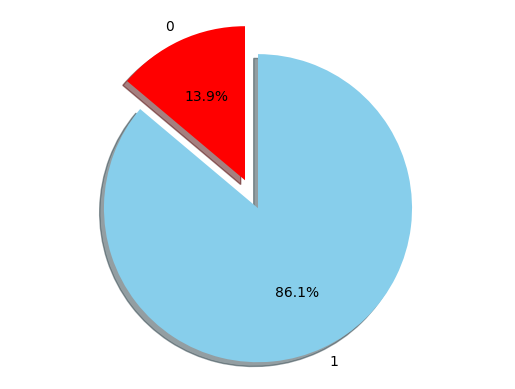

In [177]:
count_Class = pd.value_counts(dataset.label, sort = True)
# Data to Plot
labels = '0', '1'
sizes = [count_Class[0], count_Class[1]]
colors = ['red', 'skyblue']
explode = (0.1, 0.1)
# Plot
plt.pie(sizes, explode = explode, labels = labels, colors = colors,
        autopct = '%1.1f%%', shadow = True, startangle = 90)
plt.axis('equal')
plt.show()

In [178]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

In [179]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [180]:
def preprocess_text(sen):
    sentence = re.sub('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)',' ',sen) # Removing html tags
    sentence = re.sub('[^a-zA-Z]', ' ', sentence) # Remove punctuations and numbers
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence) # Single character removal
    sentence = re.sub(r'\s+', ' ', sentence) # Removing multiple spaces
    sentence = sentence.replace("ain't", "am not").replace("aren't", "are not")
    sentence = ' '.join(text.lower() for text in sentence.split(' ')) # Lowering cases
    sw = stopwords.words('english')
    sentence = ' '.join(text for text in sentence.split() if text not in sw) #removing stopwords
    #sentence = ' '.join(text.lemmatize() for text in sentence.split()) #lemmatization
    return sentence

In [181]:
dataset['message'] = dataset.message.apply(preprocess_text)
dataset['message'] = dataset['message'].apply(nltk.word_tokenize)
stemmer = PorterStemmer()
dataset['message'] = dataset['message'].apply(lambda x: [stemmer.stem(y) for y in x])
show = dataset['message']
show.head()

0    [switchfoot, bummer, shoulda, got, david, carr...
1                       [upset, updat, facebook, text]
2    [kenichan, dive, mani, time, ball, manag, save...
3               [whole, bodi, feel, itchi, like, fire]
4                   [nationwideclass, behav, mad, see]
Name: message, dtype: object

In [182]:
from sklearn.feature_extraction.text import CountVectorizer
dataset['message'] = dataset['message'].apply(lambda x: ' '.join(x))
count_vect = CountVectorizer()
counts = count_vect.fit_transform(dataset['message'])

In [183]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer().fit(counts)
counts = transformer.fit_transform(counts)

In [184]:
X = dataset['message'].values
Y = dataset['label'].values

In [185]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(counts , Y , test_size=0.2 , random_state=69)

In [186]:
X_train[:10]

<10x6248 sparse matrix of type '<class 'numpy.float64'>'
	with 69 stored elements in Compressed Sparse Row format>

NAIVE BAYES'S

In [187]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()
NB.fit(X_train,Y_train)

MultinomialNB()

In [188]:
Y_pred = NB.predict(X_test)

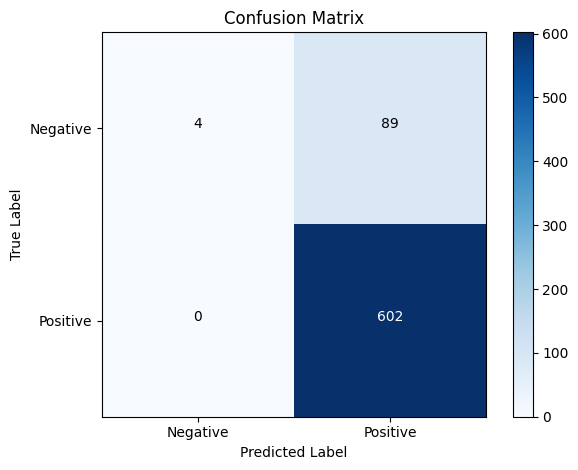

In [189]:
from sklearn.metrics import confusion_matrix , accuracy_score , classification_report
import itertools
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
cm = confusion_matrix(Y_test , Y_pred)
class_names = ['Negative', 'Positive']
plot_confusion_matrix(cm, classes=class_names)
plt.show()

In [190]:
print(accuracy_score(Y_test, Y_pred,))

0.8719424460431655


In [191]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      0.04      0.08        93
           1       0.87      1.00      0.93       602

    accuracy                           0.87       695
   macro avg       0.94      0.52      0.51       695
weighted avg       0.89      0.87      0.82       695



SUPPORT VECTOR MACHINE

In [192]:
from sklearn.svm import SVC
sv = SVC(kernel='linear')
sv.fit(X_train, Y_train)

SVC(kernel='linear')

In [193]:
Y_pred = sv.predict(X_test)

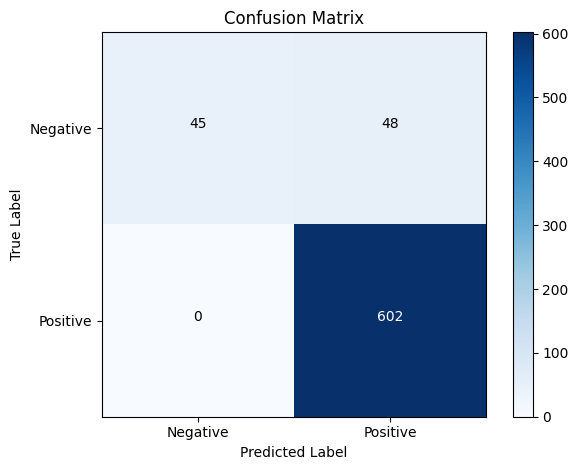

In [194]:
from sklearn.metrics import confusion_matrix , accuracy_score , classification_report
import itertools
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
cm = confusion_matrix(Y_test , Y_pred)
class_names = ['Negative', 'Positive']
plot_confusion_matrix(cm, classes=class_names)
plt.show()

In [195]:
print(accuracy_score(Y_test, Y_pred))

0.9309352517985612


In [196]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      0.48      0.65        93
           1       0.93      1.00      0.96       602

    accuracy                           0.93       695
   macro avg       0.96      0.74      0.81       695
weighted avg       0.94      0.93      0.92       695



K-Nearest Neighbors

In [197]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5 , metric="minkowski", p=2)
knn.fit(X_train,Y_train)

KNeighborsClassifier()

In [198]:
Y_pred = knn.predict(X_test)

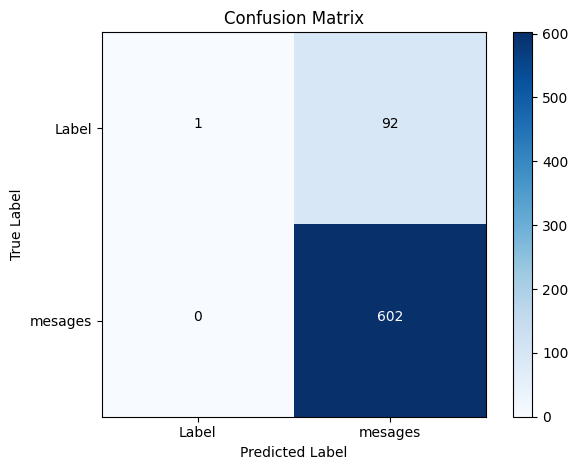

In [199]:
from sklearn.metrics import confusion_matrix , accuracy_score , classification_report
import itertools
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
cm = confusion_matrix(Y_test , Y_pred)
class_names = ['Label', 'mesages']
plot_confusion_matrix(cm, classes=class_names)
plt.show()

In [200]:
print(accuracy_score(Y_test, Y_pred))

0.8676258992805755


In [201]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      0.01      0.02        93
           1       0.87      1.00      0.93       602

    accuracy                           0.87       695
   macro avg       0.93      0.51      0.48       695
weighted avg       0.89      0.87      0.81       695



RANDON FOREST

In [202]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1000)
rf.fit(X_train,Y_train)

RandomForestClassifier(n_estimators=1000)

In [203]:
Y_pred = rf.predict(X_test)

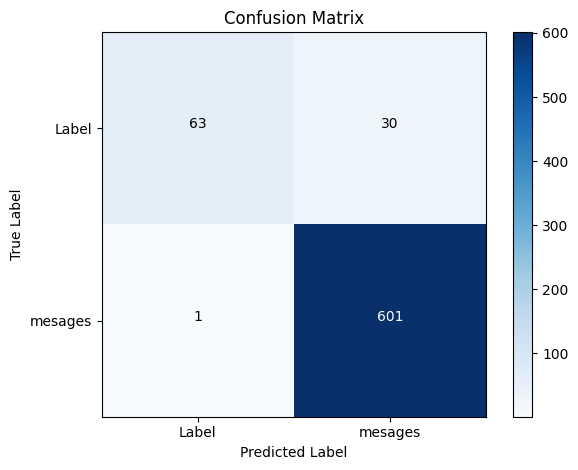

In [204]:
from sklearn.metrics import confusion_matrix , accuracy_score , classification_report
import itertools
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
cm = confusion_matrix(Y_test , Y_pred)
class_names = ['Label', 'mesages']
plot_confusion_matrix(cm, classes=class_names)
plt.show()

In [205]:
print(accuracy_score(Y_test, Y_pred))

0.9553956834532374


In [206]:
accuracy_rf = rf.score(X_test, Y_test)

In [207]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.98      0.68      0.80        93
           1       0.95      1.00      0.97       602

    accuracy                           0.96       695
   macro avg       0.97      0.84      0.89       695
weighted avg       0.96      0.96      0.95       695



LOGISTIC REGRESSION

In [208]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0)
lr.fit(X_train , Y_train)

LogisticRegression(random_state=0)

In [209]:
Y_pred = lr.predict(X_test)

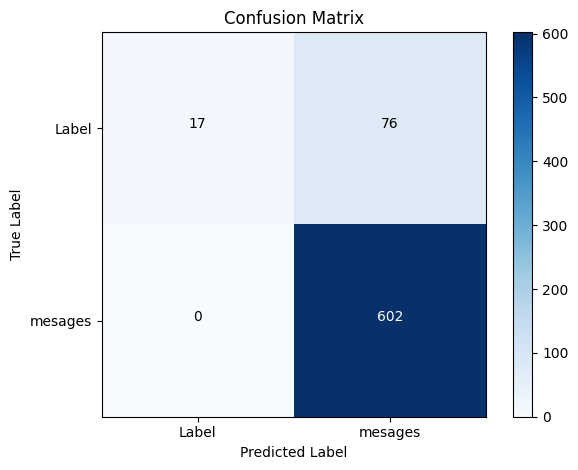

In [210]:
from sklearn.metrics import confusion_matrix , accuracy_score , classification_report
import itertools
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
cm = confusion_matrix(Y_test , Y_pred)
class_names = ['Label', 'mesages']
plot_confusion_matrix(cm, classes=class_names)
plt.show()

In [211]:
print(accuracy_score(Y_test, Y_pred))

0.8906474820143885


In [212]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      0.18      0.31        93
           1       0.89      1.00      0.94       602

    accuracy                           0.89       695
   macro avg       0.94      0.59      0.62       695
weighted avg       0.90      0.89      0.86       695



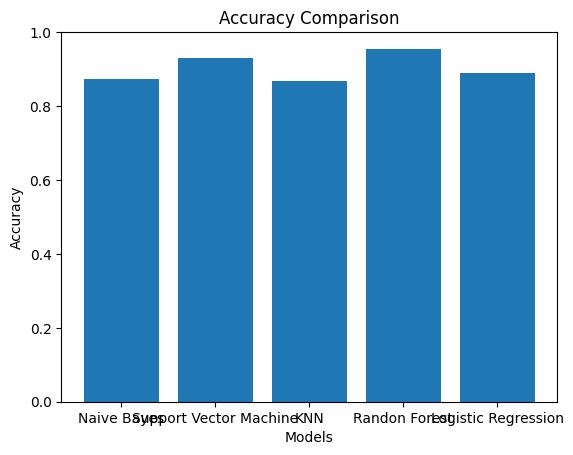

In [213]:
accuracy_NB = NB.score(X_test, Y_test)
accuracy_sv = sv.score(X_test, Y_test)
accuracy_knn = knn.score(X_test, Y_test)
accuracy_lr = lr.score(X_test, Y_test)
models = ['Naive Bayes', 'Support Vector Machine', 'KNN' ,'Randon Forest' , 'Logistic Regression']
accuracies = [accuracy_NB, accuracy_sv ,accuracy_knn , accuracy_rf,accuracy_lr]
plt.bar(models, accuracies)
plt.ylim(0, 1)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.show()

DEEP LEARNING

In [214]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [215]:
texts = dataset['message'].tolist()
labels = dataset['label'].astype(int).tolist()

In [216]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [217]:
max_sequence_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

In [218]:
labels = np.array(labels)

In [219]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

CNN

In [220]:
embedding_dim = 100
num_filters = 128
filter_size = 5
cnn = Sequential()
cnn.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length))
cnn.add(Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu'))
cnn.add(GlobalMaxPooling1D())
cnn.add(Dense(100, activation='relu'))
cnn.add(Dense(1000, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(200, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(15, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(3, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(1, activation='sigmoid'))

In [221]:
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [222]:
batch_size = 32
epochs = 5
cnn.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/5
87/87 [==============================] - 3s 18ms/step - loss: 0.6050 - accuracy: 0.7676 - val_loss: 0.5701 - val_accuracy: 0.8504
Epoch 2/5
87/87 [==============================] - 1s 14ms/step - loss: 0.5309 - accuracy: 0.8507 - val_loss: 0.4464 - val_accuracy: 0.8504
Epoch 3/5
87/87 [==============================] - 1s 14ms/step - loss: 0.4462 - accuracy: 0.8910 - val_loss: 0.2665 - val_accuracy: 0.9324
Epoch 4/5
87/87 [==============================] - 1s 13ms/step - loss: 0.3786 - accuracy: 0.9263 - val_loss: 0.3096 - val_accuracy: 0.9295
Epoch 5/5
87/87 [==============================] - 1s 13ms/step - loss: 0.3561 - accuracy: 0.9482 - val_loss: 0.2453 - val_accuracy: 0.9295


In [223]:
y_pred_prob = cnn.predict(X_test)
y_pred = np.round(y_pred_prob).astype(int)

22/22 [==============================] - 0s 3ms/step


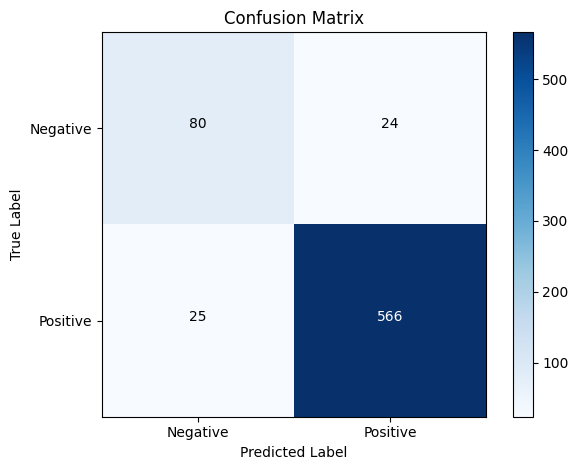

In [224]:
from sklearn.metrics import confusion_matrix, accuracy_score , classification_report
cm = confusion_matrix(y_test, y_pred)
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
class_names = ['Negative', 'Positive']
plot_confusion_matrix(cm, classes=class_names)
plt.show()

In [225]:
print(accuracy_score(y_test, y_pred))

0.9294964028776979


In [226]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.77      0.77       104
           1       0.96      0.96      0.96       591

    accuracy                           0.93       695
   macro avg       0.86      0.86      0.86       695
weighted avg       0.93      0.93      0.93       695



LSTM

In [227]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [228]:
embedding_dim = 100
lstm_units = 128
lstm = Sequential()
lstm.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length))
lstm.add(LSTM(units=lstm_units, dropout=0.2, recurrent_dropout=0.2))
lstm.add(Dense(1000, activation='relu'))
lstm.add(Dropout(0.5))
lstm.add(Dense(200, activation='relu'))
lstm.add(Dropout(0.5))
lstm.add(Dense(15, activation='relu'))
lstm.add(Dropout(0.5))
lstm.add(Dense(3, activation='relu'))
lstm.add(Dropout(0.5))
lstm.add(Dense(1, activation='sigmoid'))

In [229]:
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [230]:
batch_size = 32
epochs = 5
lstm.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/5
87/87 [==============================] - 9s 64ms/step - loss: 0.6779 - accuracy: 0.8504 - val_loss: 0.6640 - val_accuracy: 0.8504
Epoch 2/5
87/87 [==============================] - 5s 52ms/step - loss: 0.6489 - accuracy: 0.8640 - val_loss: 0.6376 - val_accuracy: 0.8504
Epoch 3/5
87/87 [==============================] - 5s 60ms/step - loss: 0.6227 - accuracy: 0.8640 - val_loss: 0.6136 - val_accuracy: 0.8504
Epoch 4/5
87/87 [==============================] - 4s 51ms/step - loss: 0.5989 - accuracy: 0.8640 - val_loss: 0.5921 - val_accuracy: 0.8504
Epoch 5/5
87/87 [==============================] - 4s 50ms/step - loss: 0.5774 - accuracy: 0.8640 - val_loss: 0.5726 - val_accuracy: 0.8504


In [231]:
y_pred_prob = lstm.predict(X_test)
y_pred = np.round(y_pred_prob).astype(int)

22/22 [==============================] - 1s 12ms/step


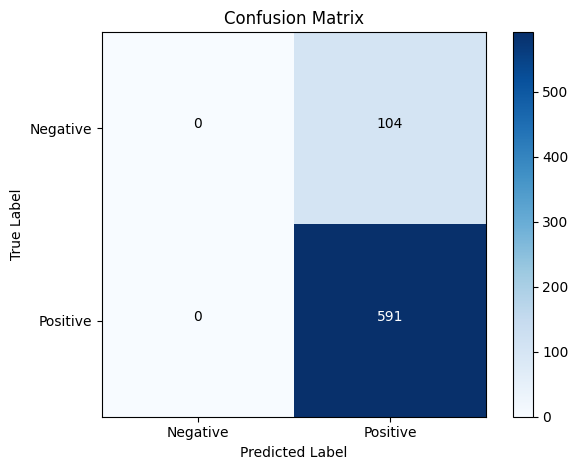

In [232]:
from sklearn.metrics import confusion_matrix, accuracy_score , classification_report
cm = confusion_matrix(y_test, y_pred)
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
class_names = ['Negative', 'Positive']
plot_confusion_matrix(cm, classes=class_names)
plt.show()

In [233]:
print(accuracy_score(y_test, y_pred))

0.8503597122302158


In [234]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       104
           1       0.85      1.00      0.92       591

    accuracy                           0.85       695
   macro avg       0.43      0.50      0.46       695
weighted avg       0.72      0.85      0.78       695



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


VOTING CLASSIFIER

In [235]:
cnn_train_features = cnn.predict(X_train)
cnn_test_features = cnn.predict(X_test)
random_forest_model = RandomForestClassifier(n_estimators=100)
X_train_rf = np.concatenate([X_train, cnn_train_features], axis=1)
X_test_rf = np.concatenate([X_test, cnn_test_features], axis=1)

22/22 [==============================] - 0s 4ms/step


In [236]:
from sklearn.ensemble import VotingClassifier
voting_classifier = VotingClassifier(
    estimators=[('rf', random_forest_model)],
    voting='hard'
)

In [237]:
voting_classifier.fit(X_train_rf, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier())])

In [238]:
accuracy = voting_classifier.score(X_test_rf, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.9424460431654677


In [ ]:
accuracy_cnn = cnn.evaluate(X_test, y_test, verbose=0)[1]
accuracy_voting = voting_classifier.score(X_test_rf, y_test)
models = ['Random Forest', 'CNN', 'Voting Classifier']
accuracies = [accuracy_rf, accuracy_cnn, accuracy_voting]
plt.bar(models, accuracies)
plt.ylim(0, 1)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.show()

In [ ]:
text = input("Enter the tweet : ")
sequences = tokenizer.texts_to_sequences([text])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)
cnn_features = cnn.predict(padded_sequences)
features = np.concatenate([padded_sequences, cnn_features], axis=1)
prediction = voting_classifier.predict(features)
if prediction[0] == 1:
    print("compromised")
else:
    print("Not compromised")